<a href="https://colab.research.google.com/github/Mahantesh-Pattadkal-1993/CounterFactuals_GANs/blob/main/Counterfactual_Computation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#Setting up the path for GAN Training
import os
os.chdir('/content/gdrive/MyDrive/Github/CounterFactuals_GANs/MNIST')

In [3]:
#Import the libraries 
import torch
import torch.optim as opt
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from GAN_Models import DC_Generator, DC_Discriminator, Net, CNN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0




# Set random seed for reproducibility
manualSeed = 2021
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


Random Seed:  2021


In [4]:
#Load the Generator  
G = DC_Generator(1,100,28)
D = DC_Discriminator(nc=1,ndf =28)

checkpoint = torch.load("Weights/G_checkpoint_latest_99.pth", map_location=torch.device('cpu'))
G.load_state_dict(checkpoint['state_dict'])

checkpoint = torch.load("Weights/D_checkpoint_latest_99.pth", map_location=torch.device('cpu'))
D.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [5]:
#Load the Classifier
Classifier_model = Net()
Classifier_checkpoint = torch.load("Weights/Classifier.pth", map_location=torch.device('cpu'))
Classifier_model.load_state_dict(Classifier_checkpoint['state_dict'])
Classifier_model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
#Load Eoins Classifier
Classifier_model_eoin = CNN()
Classifier_checkpoint = torch.load("Weights/pytorch_cnn.pth", map_location=torch.device('cpu'))
#Classifier_model.load_state_dict(Classifier_checkpoint['state_dict'])
Classifier_model_eoin.eval()

# Gettin weird predictions, maybe the state dict is missing

In [6]:
#Loading the data

mb_size = 64

transform = transforms.ToTensor()

trainData = torchvision.datasets.MNIST('./data/', download=True, transform=transform, train=True)

trainLoader = torch.utils.data.DataLoader(trainData, shuffle=True, batch_size=mb_size)

dataIter = iter(trainLoader)

imgs, labels = dataIter.next()
print(imgs.shape)


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


torch.Size([64, 1, 28, 28])


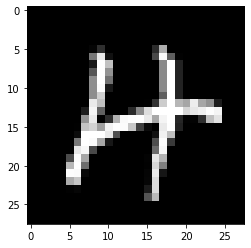

In [11]:
dataIter = iter(trainLoader)

imgs, labels = dataIter.next()
sample_image = imgs[0,:,:,:] #first image in this batch 
sample_image= sample_image.reshape([1,1,28,28])

npimgs = sample_image[0].detach().numpy()
plt.imshow(npimgs[0],cmap='Greys_r')

In [26]:
import torch
torch.manual_seed(100)
z = torch.randn(1, 100,1,1).to(device)
step_size = 0.001

avg_loss step  500tensor(49.5241, grad_fn=<DivBackward0>)
avg_loss_old step 5001000
avg_loss step  1000tensor(37.5040, grad_fn=<DivBackward0>)
avg_loss_old step 1000tensor(49.5241, grad_fn=<DivBackward0>)
avg_loss step  1500tensor(35.6153, grad_fn=<DivBackward0>)
avg_loss_old step 1500tensor(37.5040, grad_fn=<DivBackward0>)
avg_loss step  2000tensor(33.7706, grad_fn=<DivBackward0>)
avg_loss_old step 2000tensor(35.6153, grad_fn=<DivBackward0>)
avg_loss step  2500tensor(31.7434, grad_fn=<DivBackward0>)
avg_loss_old step 2500tensor(33.7706, grad_fn=<DivBackward0>)
avg_loss step  3000tensor(29.4205, grad_fn=<DivBackward0>)
avg_loss_old step 3000tensor(31.7434, grad_fn=<DivBackward0>)
avg_loss step  3500tensor(28.6807, grad_fn=<DivBackward0>)
avg_loss_old step 3500tensor(29.4205, grad_fn=<DivBackward0>)
avg_loss step  4000tensor(28.0653, grad_fn=<DivBackward0>)
avg_loss_old step 4000tensor(28.6807, grad_fn=<DivBackward0>)
avg_loss step  4500tensor(27.4834, grad_fn=<DivBackward0>)
avg_loss_o

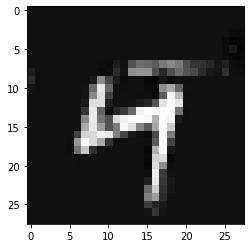

In [27]:
#find the z_org that respresents the latent representation of given image

def latent_representation(z,sample_image,pred):
  overall_loss = 0
  loss = 0
  avg_loss = 1000
  avg_loss_old = 1000
  i=1
  while (avg_loss_old>=avg_loss):
    z.requires_grad = True
    loss1 = torch.square(torch.abs(sample_image-G(z))).sum() 
    loss2 = torch.log(Classifier_model(G(z))[0][pred])

    #loss = loss1 - 10*loss2 - 10*loss3
    loss = loss1 - 10*loss2

    z.grad = None
    loss.backward()
    z.requires_grad = False
    z = z - z.grad * step_size
    i = i+1

    overall_loss= overall_loss + loss
    if (i%500==0):
      #print("loss " + "step " + str(i) + str (loss))
      avg_loss_old = avg_loss
      avg_loss = overall_loss/500.0
      print("avg_loss " + "step " + " " +str(i) + str (avg_loss))
      print("avg_loss_old " + "step " + str(i) + str (avg_loss_old))
      overall_loss = 0 
    
    if(i==10000):
      break

  return z

z_org = latent_representation(z,sample_image,4)

G_img= G(z_org)
npimgs = G_img[0].detach().numpy()
print(npimgs.shape)
plt.imshow(npimgs[0],cmap='Greys_r')

In [28]:
Classifier_model(G(z_org))[0]

tensor([5.8124e-20, 1.4615e-22, 1.4803e-12, 4.5612e-20, 1.0000e+00, 4.2899e-16,
        1.6857e-13, 5.9303e-14, 6.6829e-20, 3.1299e-06],
       grad_fn=<SelectBackward>)

## Latent dimension loss 

avg_loss step  500tensor([28.9334], grad_fn=<DivBackward0>)
avg_loss_old step 5001000
avg_loss step  1000tensor([3.8907], grad_fn=<DivBackward0>)
avg_loss_old step 1000tensor([28.9334], grad_fn=<DivBackward0>)
avg_loss step  1500tensor([1.4119], grad_fn=<DivBackward0>)
avg_loss_old step 1500tensor([3.8907], grad_fn=<DivBackward0>)
avg_loss step  2000tensor([0.9583], grad_fn=<DivBackward0>)
avg_loss_old step 2000tensor([1.4119], grad_fn=<DivBackward0>)
avg_loss step  2500tensor([0.8945], grad_fn=<DivBackward0>)
avg_loss_old step 2500tensor([0.9583], grad_fn=<DivBackward0>)
avg_loss step  3000tensor([0.8567], grad_fn=<DivBackward0>)
avg_loss_old step 3000tensor([0.8945], grad_fn=<DivBackward0>)
avg_loss step  3500tensor([0.8431], grad_fn=<DivBackward0>)
avg_loss_old step 3500tensor([0.8567], grad_fn=<DivBackward0>)
avg_loss step  4000tensor([0.8391], grad_fn=<DivBackward0>)
avg_loss_old step 4000tensor([0.8431], grad_fn=<DivBackward0>)
avg_loss step  4500tensor([0.8023], grad_fn=<DivBack

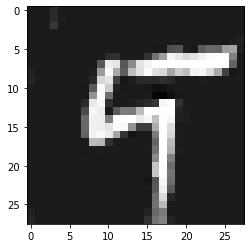

In [18]:
#using latent dimension distance and PR loss
import torch
torch.manual_seed(100)
z = torch.randn(1, 100,1,1).to(device)
step_size = 0.001


def counterfactual_eluclidian(z,z_org,target_class):

  overall_loss = 0
  loss = 0
  avg_loss = 1000
  avg_loss_old = 1000
  i=1
  while (avg_loss_old>=avg_loss):
    z.requires_grad = True
    loss1 = torch.square(torch.abs(z_org-z)).sum() 
    loss2 = torch.log(Classifier_model(G(z))[0][target_class])
    loss3 = torch.log(D(G(z)))

    loss = loss1 - 10*loss2 - loss3
    #loss = loss1 - 10*loss2

    z.grad = None
    loss.backward()
    z.requires_grad = False
    z = z - z.grad * step_size
    i = i+1

    overall_loss= overall_loss + loss
    if (i%500==0):
      #print("loss " + "step " + str(i) + str (loss))
      avg_loss_old = avg_loss
      avg_loss = overall_loss/500.0
      print("avg_loss " + "step " + " " +str(i) + str (avg_loss))
      print("avg_loss_old " + "step " + str(i) + str (avg_loss_old))
      overall_loss = 0 
  return z


z = counterfactual_eluclidian(z,z_org,5)
#Check if the image generated is close to the real image

G_img= G(z)
npimgs = G_img[0].detach().numpy()
print(npimgs.shape)
plt.imshow(npimgs[0],cmap='Greys_r')

In [17]:
Classifier_model(G(z))[0]

tensor([3.1863e-10, 1.1846e-06, 9.9174e-01, 2.1092e-08, 3.0014e-04, 8.2560e-08,
        1.4449e-10, 5.4091e-09, 1.9396e-03, 6.0206e-03],
       grad_fn=<SelectBackward>)

avg_loss step  500tensor(48.3900, grad_fn=<DivBackward0>)
avg_loss_old step 5001000
avg_loss step  1000tensor(16.9182, grad_fn=<DivBackward0>)
avg_loss_old step 1000tensor(48.3900, grad_fn=<DivBackward0>)
avg_loss step  1500tensor(13.0249, grad_fn=<DivBackward0>)
avg_loss_old step 1500tensor(16.9182, grad_fn=<DivBackward0>)
avg_loss step  2000tensor(12.7657, grad_fn=<DivBackward0>)
avg_loss_old step 2000tensor(13.0249, grad_fn=<DivBackward0>)
avg_loss step  2500tensor(12.6995, grad_fn=<DivBackward0>)
avg_loss_old step 2500tensor(12.7657, grad_fn=<DivBackward0>)
avg_loss step  3000tensor(12.6908, grad_fn=<DivBackward0>)
avg_loss_old step 3000tensor(12.6995, grad_fn=<DivBackward0>)
avg_loss step  3500tensor(12.6878, grad_fn=<DivBackward0>)
avg_loss_old step 3500tensor(12.6908, grad_fn=<DivBackward0>)
avg_loss step  4000tensor(12.6876, grad_fn=<DivBackward0>)
avg_loss_old step 4000tensor(12.6878, grad_fn=<DivBackward0>)
avg_loss step  4500tensor(12.6864, grad_fn=<DivBackward0>)
avg_loss_o

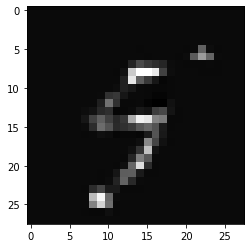

In [177]:
#using latent dimension distance and without PR loss

#This can be used as the baselines that do not talk about plausibility

import torch
torch.manual_seed(100)
z = torch.randn(1, 100,1,1).to(device)
step_size = 0.001


def counterfactual_eluclidian(z,z_org,target_class):

  overall_loss = 0
  loss = 0
  avg_loss = 1000
  avg_loss_old = 1000
  i=1
  while (avg_loss_old>=avg_loss):
    z.requires_grad = True
    loss1 = torch.square(torch.abs(z_org-z)).sum() 
    loss2 = torch.log(Classifier_model(G(z))[0][target_class])
    loss3 = torch.log(D(G(z)))

    #loss = loss1 - 10*loss2 - loss3
    loss = loss1 - 10*loss2

    z.grad = None
    loss.backward()
    z.requires_grad = False
    z = z - z.grad * step_size
    i = i+1

    overall_loss= overall_loss + loss
    if (i%500==0):
      #print("loss " + "step " + str(i) + str (loss))
      avg_loss_old = avg_loss
      avg_loss = overall_loss/500.0
      print("avg_loss " + "step " + " " +str(i) + str (avg_loss))
      print("avg_loss_old " + "step " + str(i) + str (avg_loss_old))
      overall_loss = 0 
  return z

z = counterfactual_eluclidian(z,z_org,3)

#Check if the image generated is close to the real image
G_img= G(z)
npimgs = G_img[0].detach().numpy()
print(npimgs.shape)
plt.imshow(npimgs[0],cmap='Greys_r')

avg_loss step  500tensor([2.0529], grad_fn=<DivBackward0>)
avg_loss_old step 5001000
avg_loss step  1000tensor([-0.0304], grad_fn=<DivBackward0>)
avg_loss_old step 1000tensor([2.0529], grad_fn=<DivBackward0>)
avg_loss step  1500tensor([-0.0327], grad_fn=<DivBackward0>)
avg_loss_old step 1500tensor([-0.0304], grad_fn=<DivBackward0>)
avg_loss step  2000tensor([-0.0345], grad_fn=<DivBackward0>)
avg_loss_old step 2000tensor([-0.0327], grad_fn=<DivBackward0>)
avg_loss step  2500tensor([-0.0362], grad_fn=<DivBackward0>)
avg_loss_old step 2500tensor([-0.0345], grad_fn=<DivBackward0>)
avg_loss step  3000tensor([-0.0377], grad_fn=<DivBackward0>)
avg_loss_old step 3000tensor([-0.0362], grad_fn=<DivBackward0>)
avg_loss step  3500tensor([-0.0391], grad_fn=<DivBackward0>)
avg_loss_old step 3500tensor([-0.0377], grad_fn=<DivBackward0>)
avg_loss step  4000tensor([-0.0403], grad_fn=<DivBackward0>)
avg_loss_old step 4000tensor([-0.0391], grad_fn=<DivBackward0>)
avg_loss step  4500tensor([-0.0413], grad

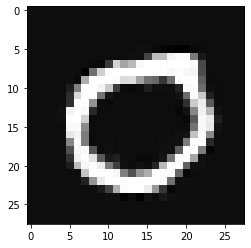

In [267]:
#using latent dimension distance but cosine similarity
import torch
cos = nn.CosineSimilarity(dim=1, eps=1e-6)

def counterfactual_cosine(z,z_org,target_class):
  #print(target_class)
  overall_loss = 0
  loss = 0
  avg_loss = 1000
  avg_loss_old = 1000
  i=1
  while (avg_loss_old>=avg_loss):
    z.requires_grad = True
    loss1 =  torch.log(0.1+torch.abs(cos(z_org,z)).mean())
    loss2 = torch.log(Classifier_model(G(z))[0][target_class])
    #print(Classifier_model(G(z))[0][target_class])
    loss3 = torch.log(D(G(z)))

    loss = -loss1 - loss2 - loss3
    #loss = loss1 - 10*loss2

    z.grad = None
    loss.backward()
    z.requires_grad = False
    z = z - z.grad * step_size
    i = i+1

    overall_loss= overall_loss + loss
    if (i%500==0):
      #print("loss " + "step " + str(i) + str (loss))
      avg_loss_old = avg_loss
      avg_loss = overall_loss/500.0
      print("avg_loss " + "step " + " " +str(i) + str (avg_loss))
      print("avg_loss_old " + "step " + str(i) + str (avg_loss_old))
      overall_loss = 0 
    if(i==10000):
      break
  return z


torch.manual_seed(100)
z = torch.randn(1, 100,1,1).to(device)
step_size = 0.01


z = counterfactual_cosine(z,z_org,0)
#Check if the image generated is close to the real image

G_img= G(z)
npimgs = G_img[0].detach().numpy()
print(npimgs.shape)
plt.imshow(npimgs[0],cmap='Greys_r')

In [264]:
Classifier_model(G(z))[0]

tensor([1.4663e-10, 5.1856e-08, 4.4245e-10, 5.4238e-10, 3.2776e-05, 1.8631e-04,
        5.8319e-09, 3.4236e-04, 9.9791e-01, 1.5309e-03],
       grad_fn=<SelectBackward>)

In [266]:
D(G(z))

tensor([0.9997], grad_fn=<SqueezeBackward1>)

###Find the image which is on a borderline i.e. semi-factual

Idea: Use the metric **Pred - argmax2nd highest** to identify the borderline semi factual

In [ ]:
#Find the image distant from the original one but still has the same class perdiction

#using latent dimension distance
cos = nn.CosineSimilarity(dim=1, eps=1e-6)

import torch
torch.manual_seed(100)
z_semi = torch.randn(1, 100,1,1).to(device)
step_size = 0.001


def semifactuals(z_org,z_semi,given_class):
  overall_loss = 0
  loss = 0
  avg_loss = 1000
  avg_loss_old = 1000
  i=1
  while (avg_loss_old>=avg_loss):
    z_semi.requires_grad = True
    #loss1 = torch.square(torch.abs(z_org-z_semi)).sum() # distance in latent dimension euclidean
    
    loss1 =  torch.log(0.1+torch.abs(cos(z_org,z_semi)).mean()) # distance using cosine similarity
    loss2 = torch.log(Classifier_model(G(z_semi))[0][given_class]) # ensure the class is maintained 
    temp = Classifier_model(G(z_semi))[0]
    loss3 = torch.log(1.1 - (temp[torch.topk(temp,2).indices[0]] - temp[torch.topk(temp,2).indices[1]])) # diference between highest and argmax 2
    loss4 = torch.log(D(G(z_semi))) # Plausibility

    
    
  #loss = loss1 - loss2 - 5*loss3 # without PR
    loss = -loss1 - loss2 - loss3 - loss4 #with PR
    z_semi.grad = None
    loss.backward()
    z_semi.requires_grad = False
    z_semi = z_semi - z_semi.grad * step_size
    i = i+1

    overall_loss= overall_loss + loss
    if (i%500==0):
      #print("loss " + "step " + str(i) + str (loss))
      avg_loss_old = avg_loss
      avg_loss = overall_loss/500.0
      print("avg_loss " + "step " + " " +str(i) + str (avg_loss))
      print("avg_loss_old " + "step " + str(i) + str (avg_loss_old))
      overall_loss = 0 
  
  if (i==10000):
    break

  return z_semi

#-------------------------------------------------------------------
# Run the function from here
given_class = 4


z_semi = semifactuals(z_semi,z_org,given_class)

G_img= G(z_semi)
npimgs = G_img[0].detach().numpy()
print(npimgs.shape)
plt.imshow(npimgs[0],cmap='Greys_r')

In [34]:
Classifier_model(G(z_semi))[0]

tensor([2.5007e-18, 3.6975e-24, 5.3301e-15, 5.0015e-22, 4.2488e-01, 5.9710e-10,
        7.9007e-18, 4.6906e-13, 1.2912e-17, 5.7512e-01],
       grad_fn=<SelectBackward>)

In [38]:
torch.topk(Classifier_model(G(z_semi))[0],2)

torch.return_types.topk(values=tensor([0.5236, 0.4764], grad_fn=<TopkBackward>), indices=tensor([4, 9]))

In [39]:
torch.topk(Classifier_model(G(z_org))[0],2)

torch.return_types.topk(values=tensor([1.0000e+00, 3.1299e-06], grad_fn=<TopkBackward>), indices=tensor([4, 9]))

###Find the image which is on a borderline i.e. semi-factual provided a target class

In [40]:
#Find the image distant from the original one but still has the same class perdiction

#using latent dimension distance

import torch
torch.manual_seed(100)
z_semi = torch.randn(1, 100,1,1).to(device)
step_size = 0.001

overall_loss = 0
loss = 0
avg_loss = 1000
avg_loss_old = 1000
i=1
while (avg_loss_old>=avg_loss):
  z_semi.requires_grad = True
  #loss1 = torch.square(torch.abs(z_org-z_semi)).sum() # distance in latent dimension
  
  loss1 = torch.log(0.1+torch.abs(cos(z_org,z_semi)).mean()) # distance using cosine similarity
  loss2 = torch.log(Classifier_model(G(z_semi))[0][4]) # ensure the class is maintained 
  #temp = Classifier_model(G(z_semi))[0]
  #loss3 = torch.log(1.1 - (temp[torch.topk(temp,2).indices[0]] - temp[torch.topk(temp,2).indices[1]])) # diference between highest and argmax 2
  loss3 = torch.log(1.1 - torch.abs((Classifier_model(G(z_semi))[0][4] - Classifier_model(G(z_semi))[0][6]))) # difference between target class and img class
  loss4 = torch.log(D(G(z_semi))) # Plausibility

  
  
  loss = -loss1 - loss2 - loss3 -loss4 # without PR
  #loss = loss1 - loss2 - 5*loss3 - loss4 #with PR
  z_semi.grad = None
  loss.backward()
  z_semi.requires_grad = False
  z_semi = z_semi - z_semi.grad * step_size
  i = i+1

  overall_loss= overall_loss + loss
  if (i%500==0):
    #print("loss " + "step " + str(i) + str (loss))
    avg_loss_old = avg_loss
    avg_loss = overall_loss/500.0
    print("avg_loss " + "step " + " " +str(i) + str (avg_loss))
    print("avg_loss_old " + "step " + str(i) + str (avg_loss_old))
    overall_loss = 0 
 

avg_loss step  500tensor([20.6390], grad_fn=<DivBackward0>)
avg_loss_old step 5001000
avg_loss step  1000tensor([13.3473], grad_fn=<DivBackward0>)
avg_loss_old step 1000tensor([20.6390], grad_fn=<DivBackward0>)
avg_loss step  1500tensor([4.3748], grad_fn=<DivBackward0>)
avg_loss_old step 1500tensor([13.3473], grad_fn=<DivBackward0>)
avg_loss step  2000tensor([1.3290], grad_fn=<DivBackward0>)
avg_loss_old step 2000tensor([4.3748], grad_fn=<DivBackward0>)
avg_loss step  2500tensor([1.3171], grad_fn=<DivBackward0>)
avg_loss_old step 2500tensor([1.3290], grad_fn=<DivBackward0>)
avg_loss step  3000tensor([1.3115], grad_fn=<DivBackward0>)
avg_loss_old step 3000tensor([1.3171], grad_fn=<DivBackward0>)
avg_loss step  3500tensor([1.3066], grad_fn=<DivBackward0>)
avg_loss_old step 3500tensor([1.3115], grad_fn=<DivBackward0>)
avg_loss step  4000tensor([1.3037], grad_fn=<DivBackward0>)
avg_loss_old step 4000tensor([1.3066], grad_fn=<DivBackward0>)
avg_loss step  4500tensor([1.3015], grad_fn=<DivBa

KeyboardInterrupt: ignored

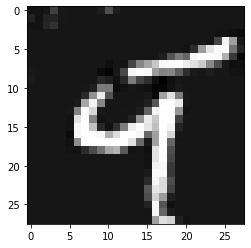

In [41]:
# Plotting the semi factual image according to the cf found by the latent dimension loss and target class provided
G_img= G(z_semi)
npimgs = G_img[0].detach().numpy()
#print(npimgs.shape)
plt.imshow(npimgs[0],cmap='Greys_r')

In [42]:
torch.topk(Classifier_model(G(z_semi))[0],2)

torch.return_types.topk(values=tensor([0.5481, 0.4519], grad_fn=<TopkBackward>), indices=tensor([4, 9]))

In [43]:
loss3

tensor(-0.5944, grad_fn=<LogBackward>)

In [44]:
torch.abs((Classifier_model(G(z_semi))[0][4] - Classifier_model(G(z_semi))[0][6]))

tensor(0.5481, grad_fn=<AbsBackward>)